# **Train and Test Set**

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dropout
from sklearn.metrics import accuracy_score
np.random.seed(42)
from google.colab import drive
!pip install keras-tuner --upgrade

import keras_tuner as kt

from matplotlib import style
style.use('fivethirtyeight')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/'
train_path = '/content/drive/MyDrive/dataset/Train'
test_path = '/content/drive/MyDrive/dataset/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 50
IMG_WIDTH = 50
channels = 3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
NUM_CATEGORIES = len(os.listdir(train_path))
print("this is the number of sign class")
NUM_CATEGORIES

this is the number of sign class


43

In [ ]:
# Label Overview finded on internet
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

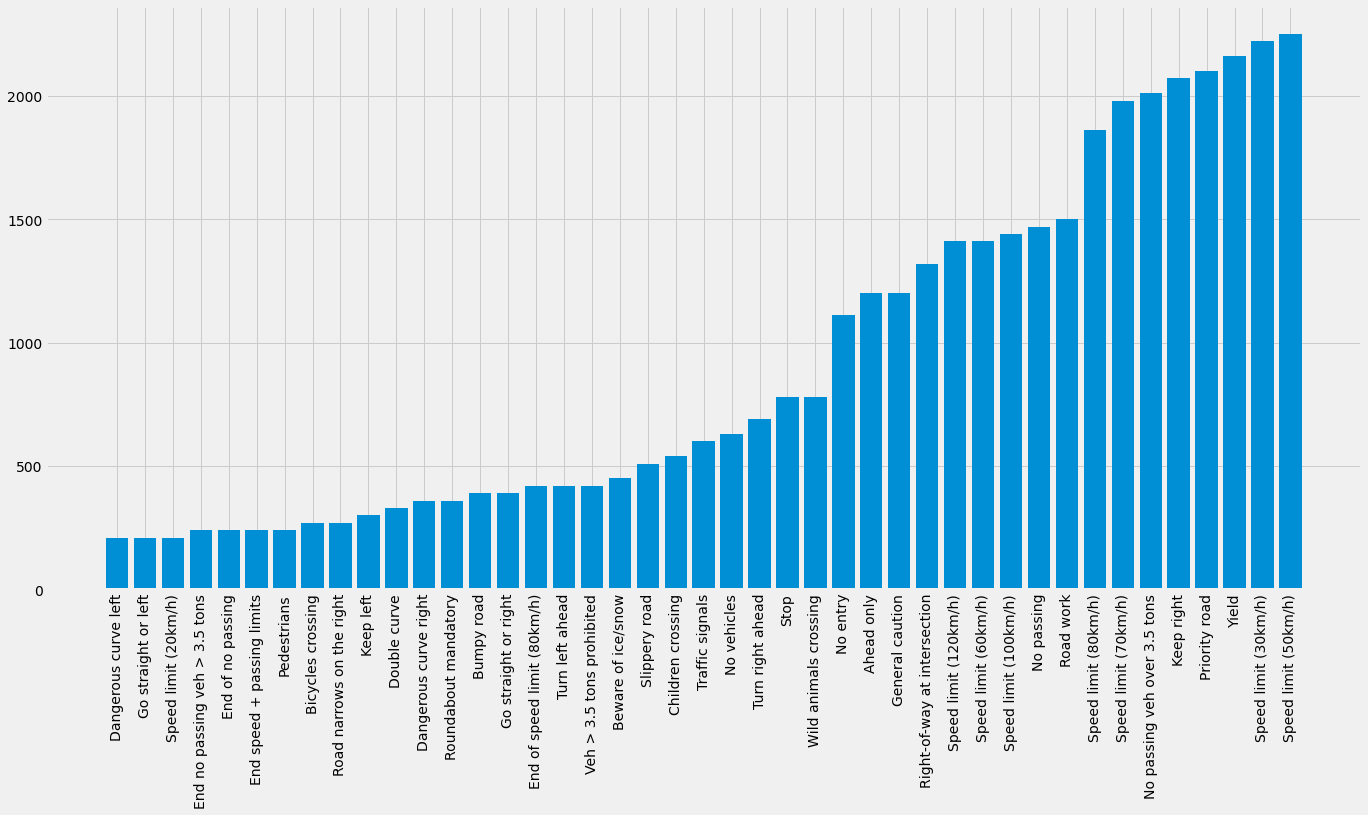

In [ ]:
#we see the distribution of our classes in the training set
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

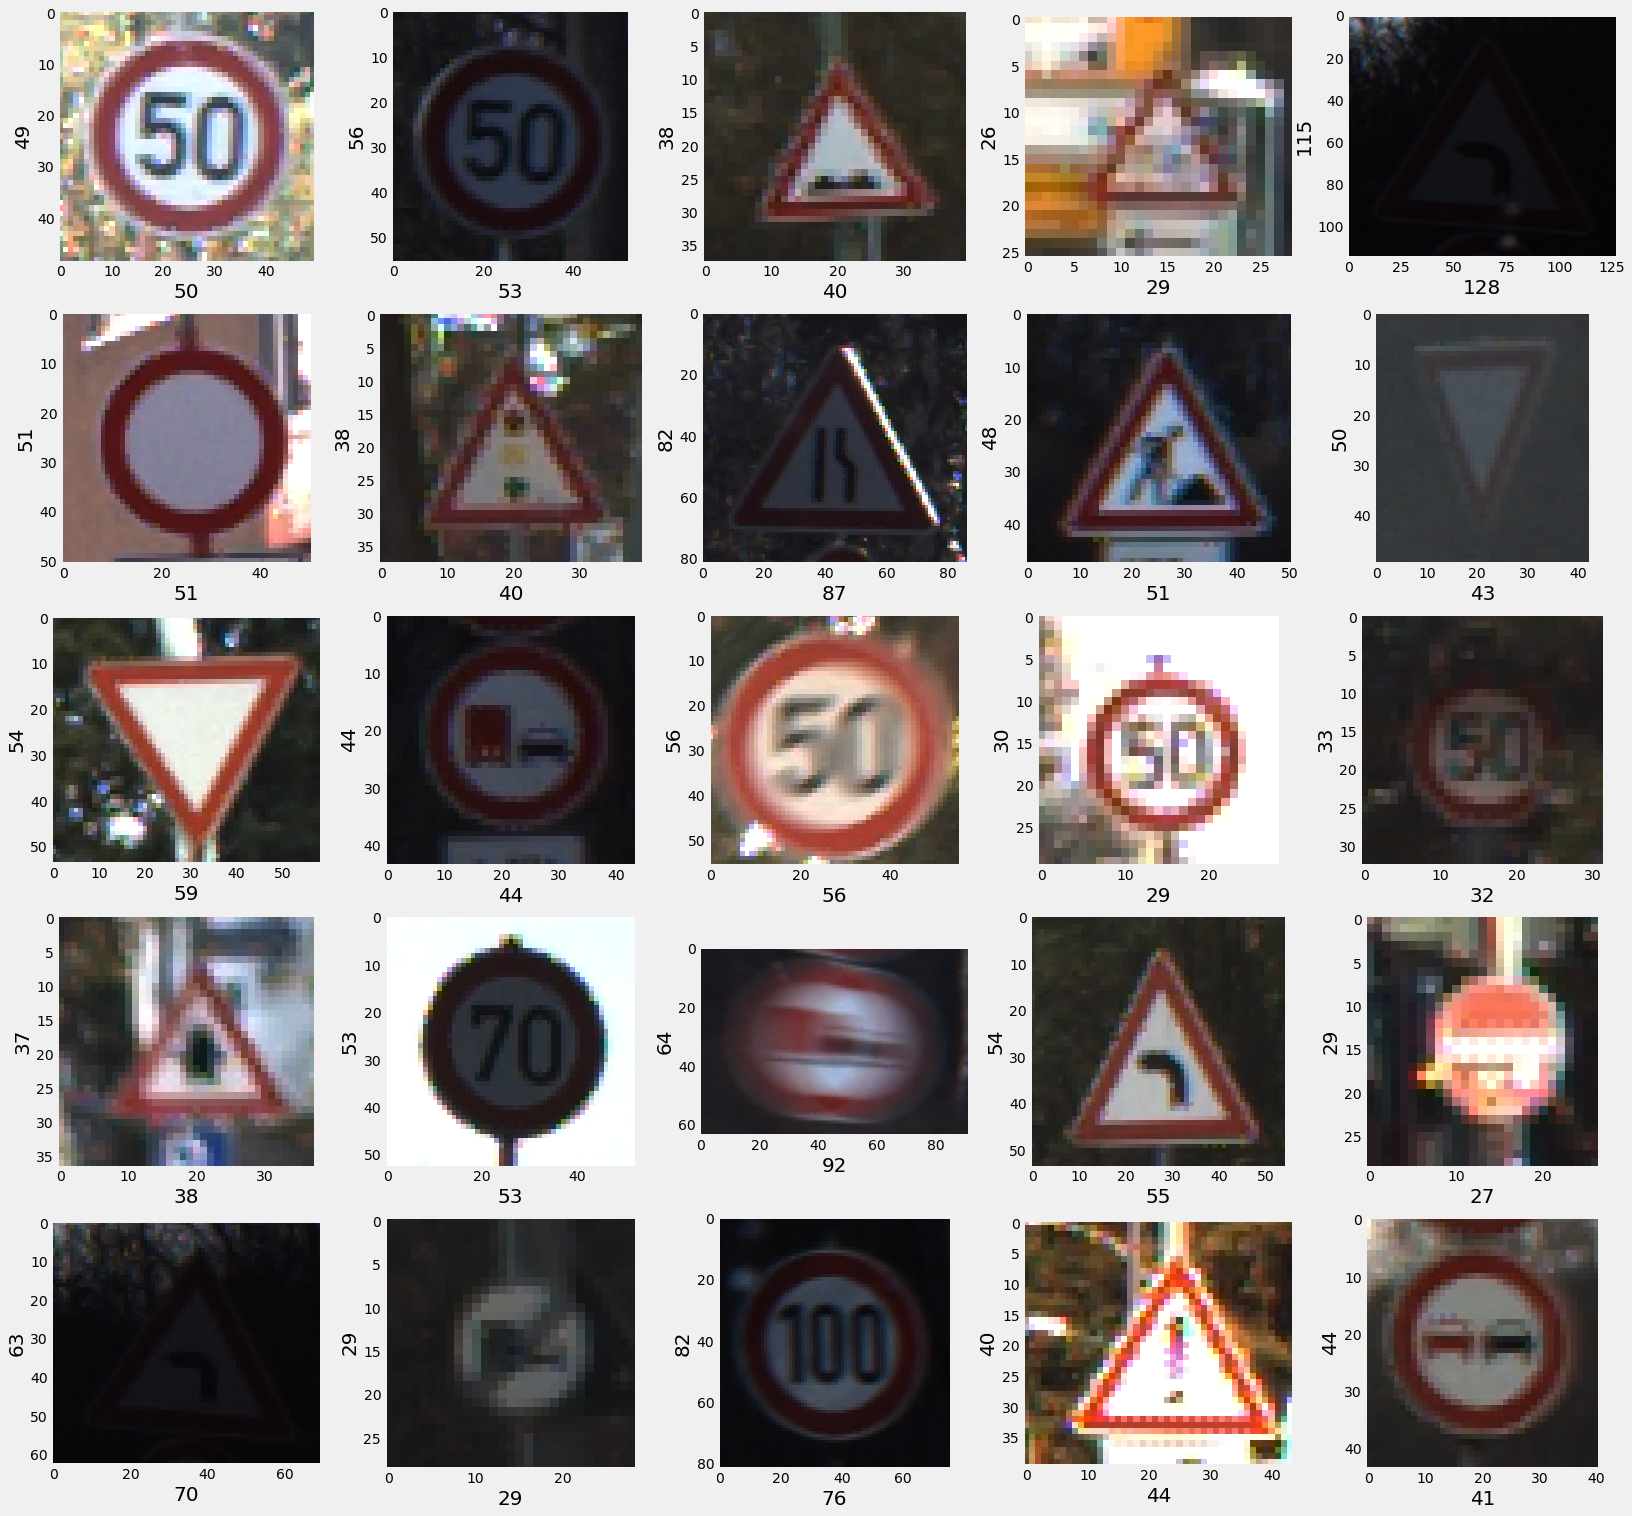

In [ ]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [ ]:
#we put all image with classes in np array
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 50, 50, 3) (39209,)


In [ ]:
#we mix the array, so when we go to create train, test and validation, we avoid having a predominance of classes
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [ ]:
#we split the train and test set , 80 - 20 
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 50, 50, 3)
X_valid.shape (7842, 50, 50, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.unique(y_train),
                                                  y = y_train)

# the field class weight in model.fit() is a dictionary, so we convert class_weights into a dictionary
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
#is maded the one hot encoding to train the keras model
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(31367, 43)
(7842, 43)


In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# **1 implementazione MNIST**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
#we made the model with the augmentation layer

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [50, 50,3]))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=64 , activation='relu',kernel_size=3))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=128 , activation='relu' ,kernel_size=3))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(250,activation='relu'))
model.add(keras.layers.Dense(43,activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']
              )

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=(X_val, y_val) , verbose = 1 , callbacks=[early_stopping], class_weight = class_weights)

Epoch 1/15
981/981 [==============================] - ETA: 0s - loss: 2.2497 - accuracy: 0.3471

981/981 [==============================] - 177s 178ms/step - loss: 2.2497 - accuracy: 0.3471 - val_loss: 0.9664 - val_accuracy: 0.6862
Epoch 2/15
981/981 [==============================] - ETA: 0s - loss: 0.9389 - accuracy: 0.6890

981/981 [==============================] - 173s 177ms/step - loss: 0.9389 - accuracy: 0.6890 - val_loss: 0.4842 - val_accuracy: 0.8262
Epoch 3/15
981/981 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.8147

981/981 [==============================] - 173s 176ms/step - loss: 0.5362 - accuracy: 0.8147 - val_loss: 0.1723 - val_accuracy: 0.9536
Epoch 4/15
981/981 [==============================] - ETA: 0s - loss: 0.3855 - accuracy: 0.8684

981/981 [==============================] - 172s 176ms/step - loss: 0.3855 - accuracy: 0.8684 - val_loss: 0.0899 - val_accuracy: 0.9795
Epoch 5/15
981/981 [==============================] - ETA: 0s - loss: 0.2925 - accuracy: 0.9014

981/981 [==============================] - 173s 176ms/step - loss: 0.2925 - accuracy: 0.9014 - val_loss: 0.0504 - val_accuracy: 0.9878
Epoch 6/15
981/981 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9211

981/981 [==============================] - 172s 176ms/step - loss: 0.2330 - accuracy: 0.9211 - val_loss: 0.0480 - val_accuracy: 0.9876
Epoch 7/15
981/981 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9303

981/981 [==============================] - 173s 176ms/step - loss: 0.2120 - accuracy: 0.9303 - val_loss: 0.0406 - val_accuracy: 0.9893
Epoch 8/15
981/981 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9402

981/981 [==============================] - 175s 178ms/step - loss: 0.1792 - accuracy: 0.9402 - val_loss: 0.0328 - val_accuracy: 0.9915
Epoch 9/15
981/981 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9445

981/981 [==============================] - 174s 177ms/step - loss: 0.1682 - accuracy: 0.9445 - val_loss: 0.0216 - val_accuracy: 0.9952
Epoch 10/15
981/981 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9484

981/981 [==============================] - 172s 176ms/step - loss: 0.1596 - accuracy: 0.9484 - val_loss: 0.0187 - val_accuracy: 0.9960
Epoch 11/15
981/981 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.9511

981/981 [==============================] - 172s 175ms/step - loss: 0.1532 - accuracy: 0.9511 - val_loss: 0.0322 - val_accuracy: 0.9909
Epoch 12/15
981/981 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9561

981/981 [==============================] - 173s 176ms/step - loss: 0.1406 - accuracy: 0.9561 - val_loss: 0.0158 - val_accuracy: 0.9967
Epoch 13/15
981/981 [==============================] - ETA: 0s - loss: 0.1404 - accuracy: 0.9554

981/981 [==============================] - 173s 176ms/step - loss: 0.1404 - accuracy: 0.9554 - val_loss: 0.0159 - val_accuracy: 0.9964
Epoch 14/15
981/981 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9570

981/981 [==============================] - 172s 175ms/step - loss: 0.1315 - accuracy: 0.9570 - val_loss: 0.0149 - val_accuracy: 0.9967
Epoch 15/15
981/981 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9593

981/981 [==============================] - 172s 175ms/step - loss: 0.1292 - accuracy: 0.9593 - val_loss: 0.0245 - val_accuracy: 0.9941


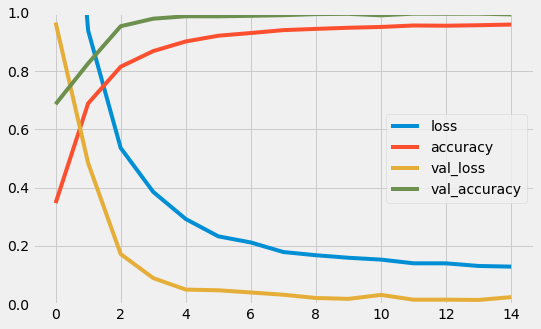

In [ ]:
model.save('/content/drive/MyDrive/dataset/model/MNIST_save2.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/dataset/model/prova2_MNIST.h5')


#test with the test set taken from file
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

# pred = model.predict_classes(X_test)

predict_x=model.predict(X_test) 
pred=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 15s 39ms/step
Test Data accuracy:  96.11243072050672


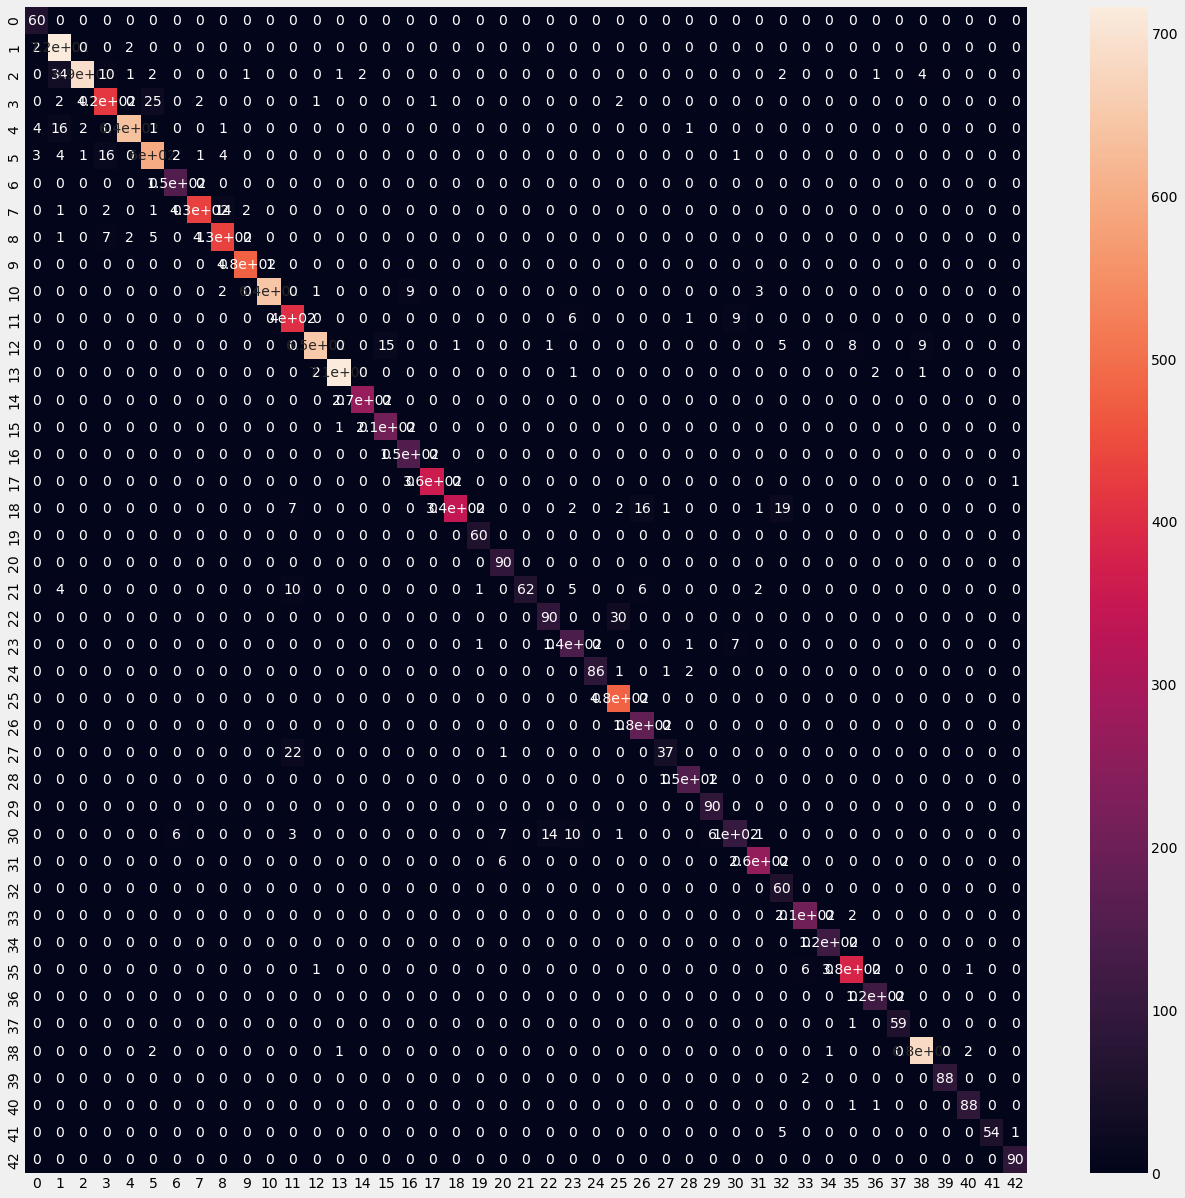

In [ ]:
#visualize confusion matrix of classifier
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [ ]:
#classification report of our model 
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        60
           1       0.92      0.99      0.96       720
           2       1.00      0.92      0.96       750
           3       0.92      0.93      0.92       450
           4       0.99      0.96      0.98       660
           5       0.94      0.95      0.95       630
           6       0.95      1.00      0.97       150
           7       0.99      0.96      0.97       450
           8       0.95      0.96      0.96       450
           9       0.99      1.00      1.00       480
          10       1.00      0.98      0.99       660
          11       0.91      0.96      0.93       420
          12       0.99      0.94      0.97       690
          13       1.00      0.99      0.99       720
          14       0.99      1.00      1.00       270
          15       0.93      1.00      0.96       210
          16       0.94      1.00      0.97       150
          17       1.00    

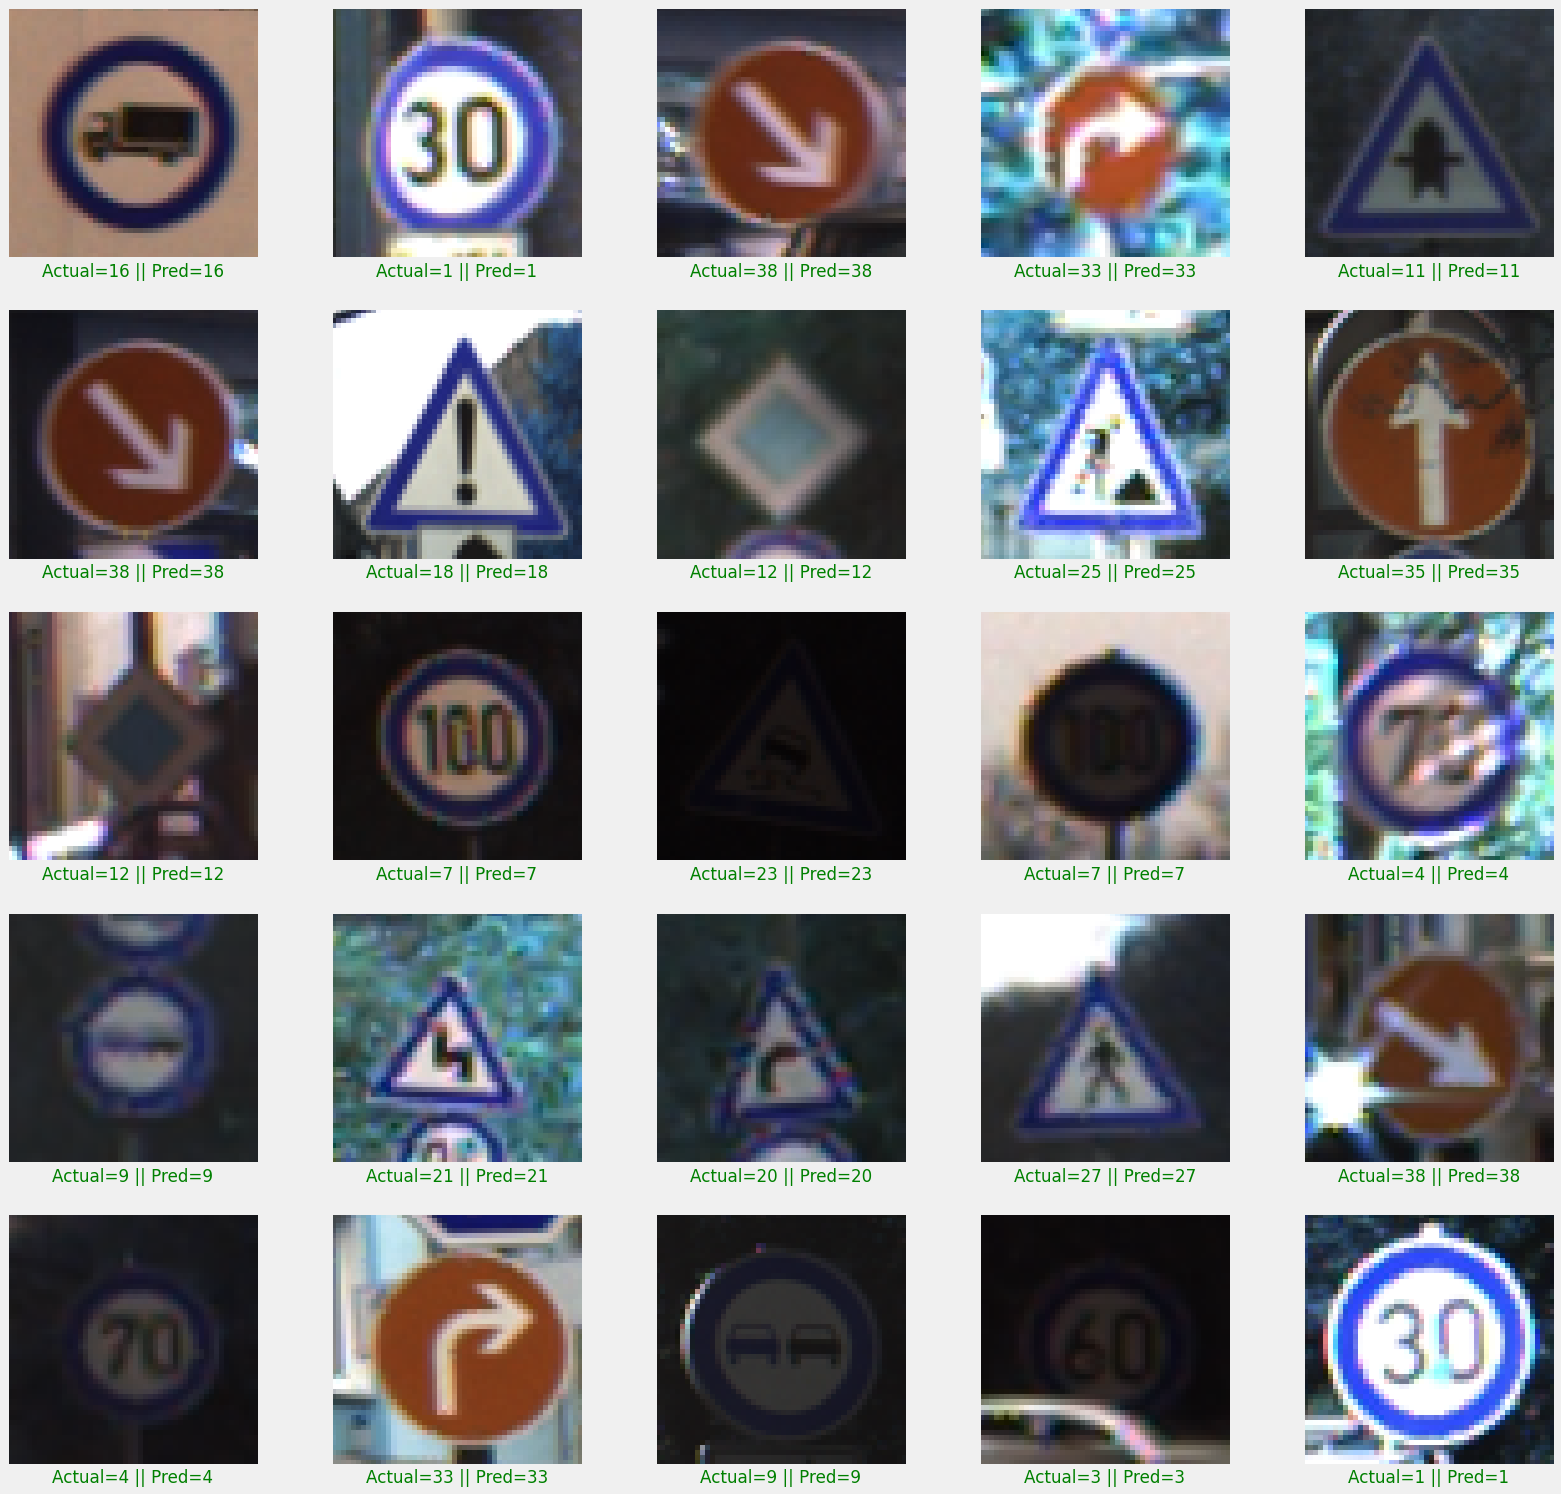

In [ ]:
#test of our classifier model
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [ ]:
#Area under the curve
from sklearn.metrics import roc_auc_score, roc_curve

for i in range(25):
    prediction = pred[i]
    actual = labels[i]
    auc = roc_auc_score(actual, prediction)
    fpr, tpr, thresholds = roc_curve(actual, prediction)
    plt.plot(fpr, tpr, lab=classes[i], label='ROC curve for class {} (AUC = {:.2f})'.format(i, auc))

# Plot the ROC curves
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

# **2 implementazione ALEX**

In [ ]:
model = keras.models.Sequential()
#1st Convolutional Layer
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [50, 50,3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#2nd Convolutional Layer
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#3rd Convolutional Layer
model.add(keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#4th Convolutional Layer
model.add(keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#Passing it to a Fully Connected layer
model.add(keras.layers.Flatten())

# 1st Fully Connected Layer
model.add(keras.layers.Dense(1024,activation='relu'))

# 2st Fully Connected Layer
model.add(keras.layers.Dense(1024,activation='relu'))

#Softmax layer for output
model.add(keras.layers.Dense(43,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 64)      

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=(X_val, y_val) , verbose = 1 , callbacks=[early_stopping], class_weight = class_weights)

Epoch 1/15
981/981 [==============================] - ETA: 0s - loss: 1.4952 - accuracy: 0.5490

981/981 [==============================] - 263s 266ms/step - loss: 1.4952 - accuracy: 0.5490 - val_loss: 0.3561 - val_accuracy: 0.8655
Epoch 2/15
981/981 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.8327

981/981 [==============================] - 258s 263ms/step - loss: 0.5485 - accuracy: 0.8327 - val_loss: 0.3293 - val_accuracy: 0.8979
Epoch 3/15
981/981 [==============================] - ETA: 0s - loss: 0.4238 - accuracy: 0.8811

981/981 [==============================] - 258s 263ms/step - loss: 0.4238 - accuracy: 0.8811 - val_loss: 0.1283 - val_accuracy: 0.9638
Epoch 4/15
981/981 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.9066

981/981 [==============================] - 261s 266ms/step - loss: 0.3403 - accuracy: 0.9066 - val_loss: 0.1808 - val_accuracy: 0.9466
Epoch 5/15
981/981 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.9207

981/981 [==============================] - 257s 262ms/step - loss: 0.3245 - accuracy: 0.9207 - val_loss: 0.1127 - val_accuracy: 0.9660
Epoch 6/15
981/981 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.9353

981/981 [==============================] - 257s 262ms/step - loss: 0.2679 - accuracy: 0.9353 - val_loss: 0.1714 - val_accuracy: 0.9597
Epoch 7/15
981/981 [==============================] - ETA: 0s - loss: 0.2431 - accuracy: 0.9431

981/981 [==============================] - 258s 263ms/step - loss: 0.2431 - accuracy: 0.9431 - val_loss: 0.0866 - val_accuracy: 0.9787
Epoch 8/15
981/981 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.9458

981/981 [==============================] - 256s 261ms/step - loss: 0.2388 - accuracy: 0.9458 - val_loss: 0.0561 - val_accuracy: 0.9847
Epoch 9/15
981/981 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9500

981/981 [==============================] - 258s 263ms/step - loss: 0.2050 - accuracy: 0.9500 - val_loss: 0.0619 - val_accuracy: 0.9801
Epoch 10/15
981/981 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9547

981/981 [==============================] - 259s 264ms/step - loss: 0.2038 - accuracy: 0.9547 - val_loss: 0.0648 - val_accuracy: 0.9829
Epoch 11/15
981/981 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9537

981/981 [==============================] - 259s 264ms/step - loss: 0.2012 - accuracy: 0.9537 - val_loss: 0.0368 - val_accuracy: 0.9925
Epoch 12/15
981/981 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.9572

981/981 [==============================] - 262s 267ms/step - loss: 0.1886 - accuracy: 0.9572 - val_loss: 0.0470 - val_accuracy: 0.9895
Epoch 13/15
981/981 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9612

981/981 [==============================] - 258s 263ms/step - loss: 0.1938 - accuracy: 0.9612 - val_loss: 0.0396 - val_accuracy: 0.9901
Epoch 14/15
981/981 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9622

981/981 [==============================] - 257s 262ms/step - loss: 0.1885 - accuracy: 0.9622 - val_loss: 0.0294 - val_accuracy: 0.9929
Epoch 15/15
981/981 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.9640

981/981 [==============================] - 258s 263ms/step - loss: 0.1778 - accuracy: 0.9640 - val_loss: 0.0454 - val_accuracy: 0.9902


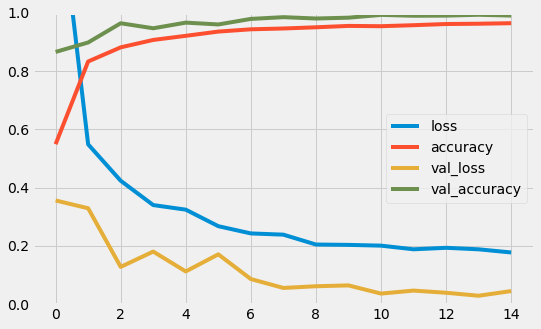

In [ ]:
model.save('/content/drive/MyDrive/dataset/model/Alex2.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#test with the test set taken from file
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

# pred = model.predict_classes(X_test)
predict_x=model.predict(X_test) 
pred=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 22s 55ms/step
Test Data accuracy:  96.01741884402217


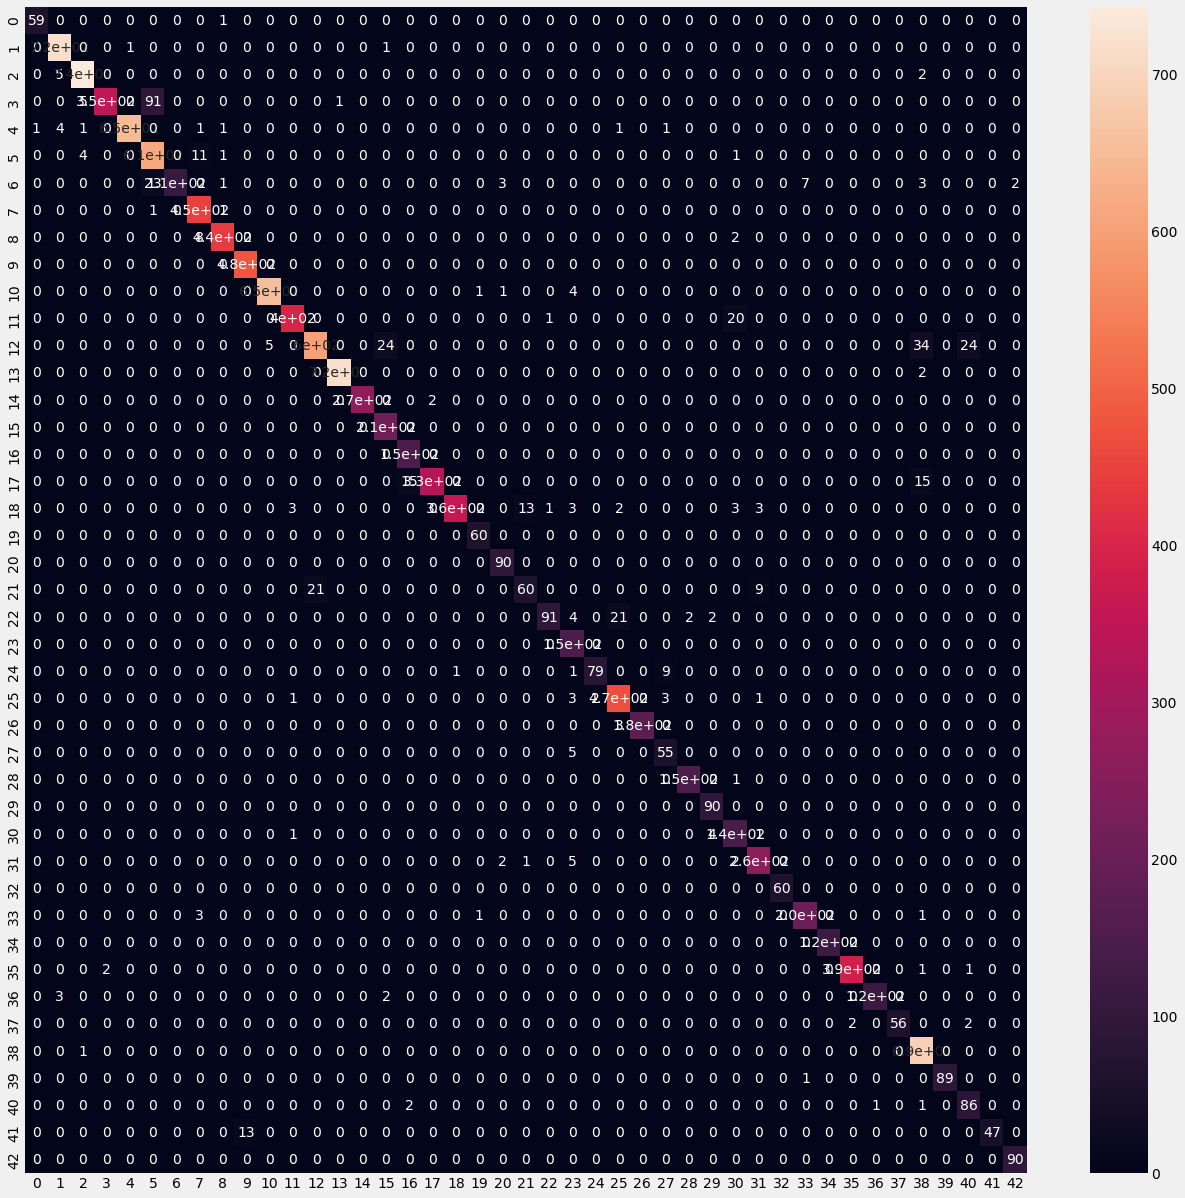

In [ ]:
#visualize confusion matrix of classifier
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [ ]:
#classification report of our model 
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        60
           1       0.98      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       0.99      0.78      0.88       450
           4       1.00      0.98      0.99       660
           5       0.84      0.97      0.90       630
           6       1.00      0.74      0.85       150
           7       0.95      1.00      0.97       450
           8       0.99      0.98      0.98       450
           9       0.97      1.00      0.99       480
          10       0.99      0.99      0.99       660
          11       0.99      0.95      0.97       420
          12       0.97      0.87      0.92       690
          13       1.00      1.00      1.00       720
          14       1.00      0.99      1.00       270
          15       0.89      1.00      0.94       210
          16       0.90      1.00      0.95       150
          17       0.99    

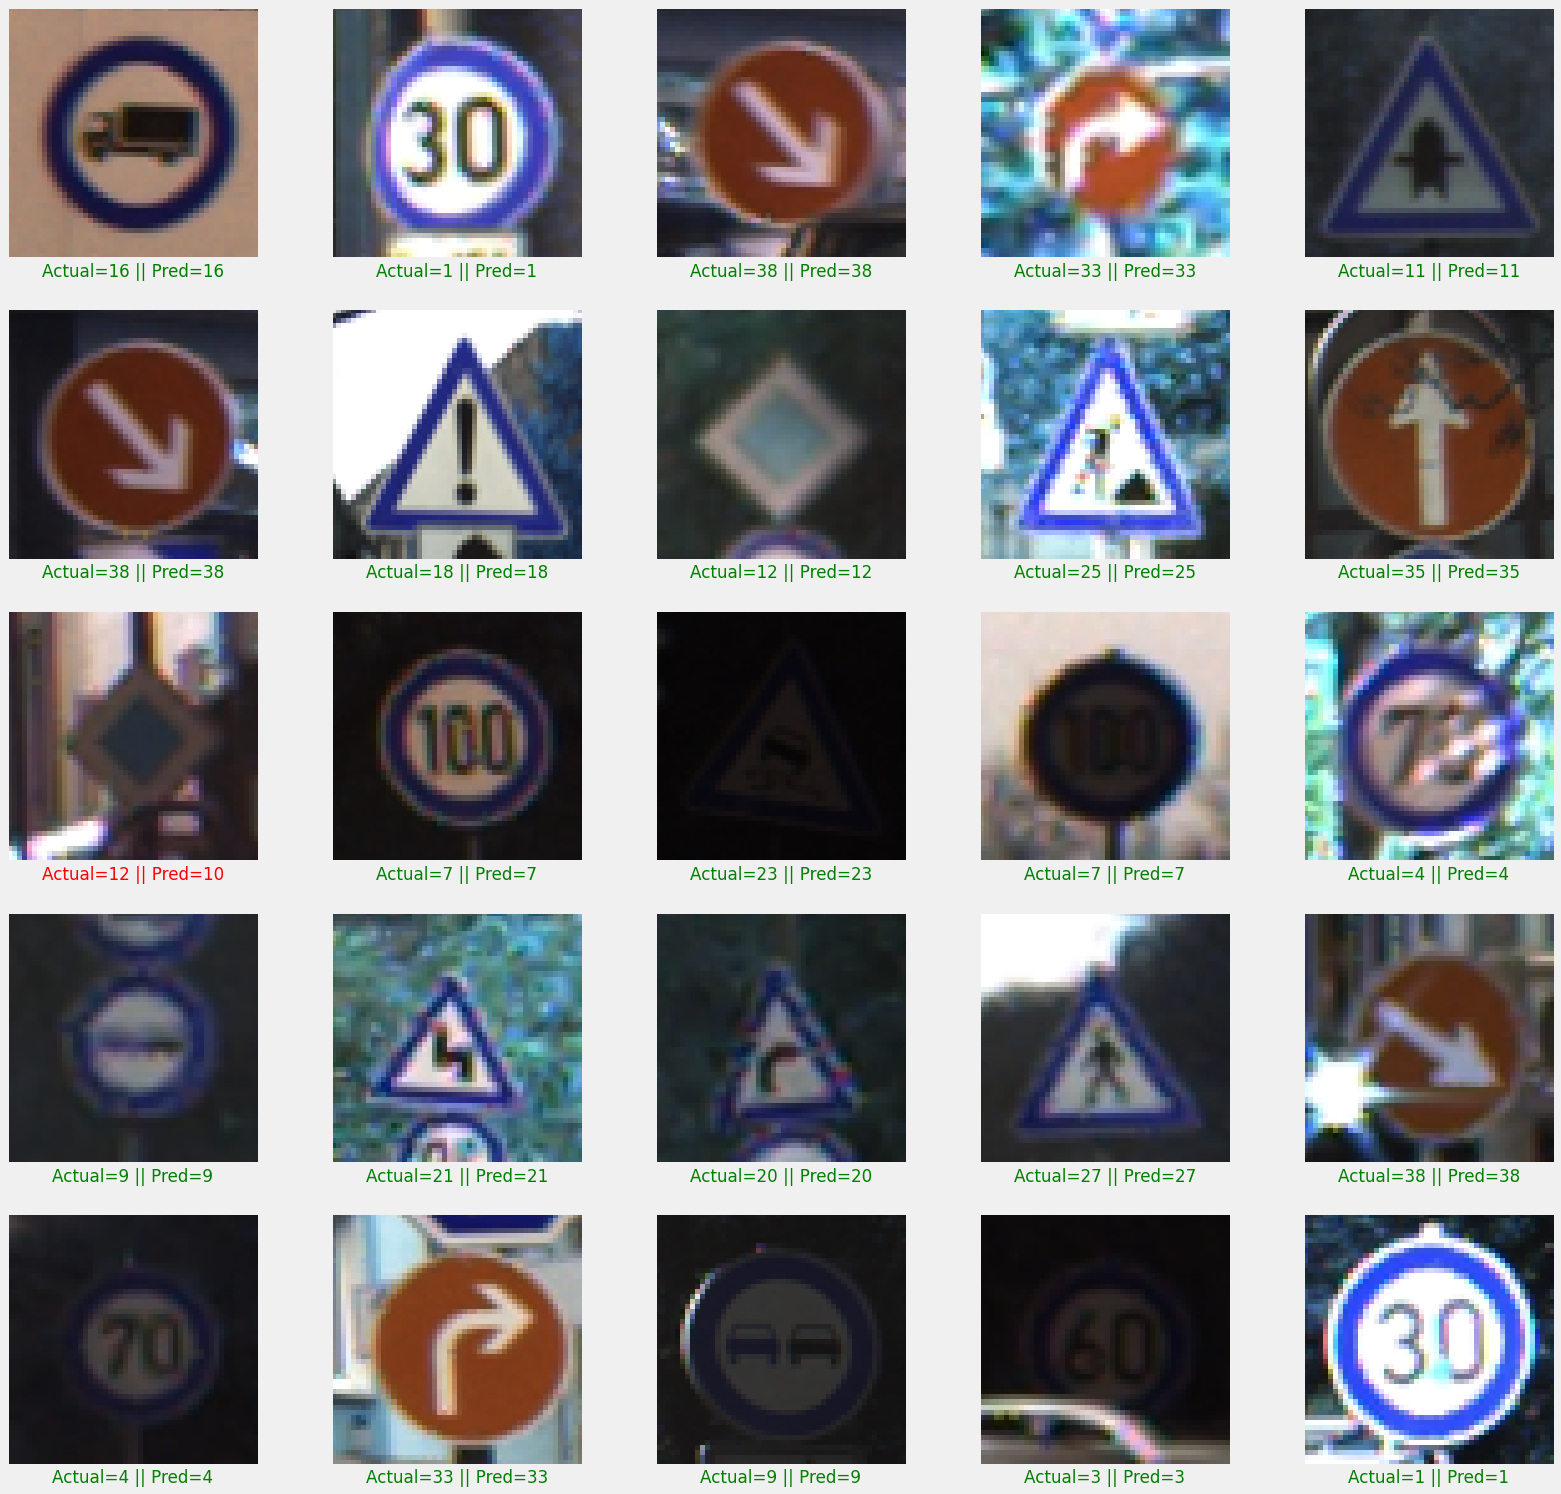

In [ ]:
#test of our classifier model
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


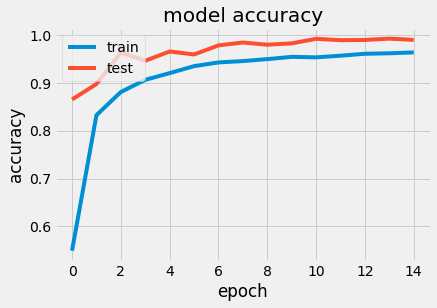

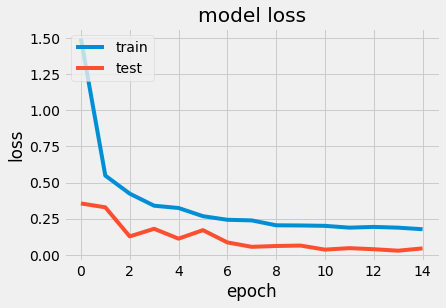

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Area under the curve
from sklearn.metrics import roc_auc_score, roc_curve

for i in range(25):
    prediction = pred[i]
    actual = labels[i]
    auc = roc_auc_score(actual, prediction)
    fpr, tpr, thresholds = roc_curve(actual, prediction)
    plt.plot(fpr, tpr, lab=classes[i], label='ROC curve for class {} (AUC = {:.2f})'.format(i, auc))

# Plot the ROC curves
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

# **Hyper Tuning MNIST**

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [50, 50,3]))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(keras.layers.Conv2D(filters=64 , activation='relu',kernel_size=3))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(keras.layers.Conv2D(filters=128 , activation='relu' ,kernel_size=3))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units,activation='sigmoid'))
  model.add(keras.layers.Dense(43,activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

  return model

In [ ]:
import datetime
# Create permanent folder in Google Drive
my_dir = "/content/drive/My Drive/modelData/Tensorboard"
if not os.path.exists(my_dir):
  os.makedirs(my_dir)
log_dir = my_dir + "/logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

In [ ]:


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=20,
                     factor=3,
                     directory=log_dir,
                     project_name='kerasTuner_mnist')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tensorboard = keras.callbacks.TensorBoard(log_dir)
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[stop_early, tensorboard])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. \
        The optimal number of units in the first densely-connected layer is {best_hps.get('units')} and \
        the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")


Trial 30 Complete [00h 01m 41s]
val_accuracy: 0.9862926602363586

Best val_accuracy So Far: 0.9976091980934143
Total elapsed time: 00h 22m 49s
The hyperparameter search is complete.         The optimal number of units in the first densely-connected layer is 512 and         the optimal learning rate for the optimizer is 0.001.


In [ ]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir "$log_dir"
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_val, y_val) , verbose = 1 ,callbacks=[early_stopping])


val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

<IPython.core.display.Javascript object>

Epoch 1/50
981/981 [==============================] - ETA: 0s - loss: 1.7046 - accuracy: 0.4852

981/981 [==============================] - 30s 30ms/step - loss: 1.7046 - accuracy: 0.4852 - val_loss: 0.4856 - val_accuracy: 0.8577
Epoch 2/50
980/981 [============================>.] - ETA: 0s - loss: 0.6267 - accuracy: 0.8002

981/981 [==============================] - 28s 28ms/step - loss: 0.6263 - accuracy: 0.8004 - val_loss: 0.1273 - val_accuracy: 0.9654
Epoch 3/50
981/981 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8805

981/981 [==============================] - 28s 28ms/step - loss: 0.3638 - accuracy: 0.8805 - val_loss: 0.0732 - val_accuracy: 0.9804
Epoch 4/50
980/981 [============================>.] - ETA: 0s - loss: 0.2461 - accuracy: 0.9216

981/981 [==============================] - 29s 29ms/step - loss: 0.2460 - accuracy: 0.9216 - val_loss: 0.0360 - val_accuracy: 0.9913
Epoch 5/50
981/981 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9379

981/981 [==============================] - 28s 29ms/step - loss: 0.1971 - accuracy: 0.9379 - val_loss: 0.0233 - val_accuracy: 0.9932
Epoch 6/50
980/981 [============================>.] - ETA: 0s - loss: 0.1676 - accuracy: 0.9474

981/981 [==============================] - 28s 28ms/step - loss: 0.1675 - accuracy: 0.9475 - val_loss: 0.0144 - val_accuracy: 0.9962
Epoch 7/50
981/981 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9551

981/981 [==============================] - 29s 29ms/step - loss: 0.1435 - accuracy: 0.9551 - val_loss: 0.0219 - val_accuracy: 0.9940
Epoch 8/50
980/981 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9572

981/981 [==============================] - 28s 28ms/step - loss: 0.1334 - accuracy: 0.9571 - val_loss: 0.0198 - val_accuracy: 0.9939
Epoch 9/50
981/981 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9623

981/981 [==============================] - 32s 33ms/step - loss: 0.1185 - accuracy: 0.9623 - val_loss: 0.0128 - val_accuracy: 0.9966
Epoch 10/50
980/981 [============================>.] - ETA: 0s - loss: 0.1107 - accuracy: 0.9674

981/981 [==============================] - 29s 29ms/step - loss: 0.1106 - accuracy: 0.9674 - val_loss: 0.0127 - val_accuracy: 0.9976
Epoch 11/50
980/981 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.9696

981/981 [==============================] - 28s 28ms/step - loss: 0.1009 - accuracy: 0.9696 - val_loss: 0.0104 - val_accuracy: 0.9973
Epoch 12/50
981/981 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9708

981/981 [==============================] - 28s 29ms/step - loss: 0.0942 - accuracy: 0.9708 - val_loss: 0.0132 - val_accuracy: 0.9969
Epoch 13/50
981/981 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.9724

981/981 [==============================] - 29s 29ms/step - loss: 0.0935 - accuracy: 0.9724 - val_loss: 0.0083 - val_accuracy: 0.9983
Epoch 14/50
980/981 [============================>.] - ETA: 0s - loss: 0.0928 - accuracy: 0.9728

981/981 [==============================] - 28s 29ms/step - loss: 0.0927 - accuracy: 0.9729 - val_loss: 0.0098 - val_accuracy: 0.9973
Epoch 15/50
980/981 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9734

981/981 [==============================] - 29s 29ms/step - loss: 0.0919 - accuracy: 0.9734 - val_loss: 0.0106 - val_accuracy: 0.9978
Epoch 16/50
980/981 [============================>.] - ETA: 0s - loss: 0.0872 - accuracy: 0.9745

981/981 [==============================] - 28s 29ms/step - loss: 0.0872 - accuracy: 0.9745 - val_loss: 0.0072 - val_accuracy: 0.9990
Epoch 17/50
981/981 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9755

981/981 [==============================] - 33s 33ms/step - loss: 0.0877 - accuracy: 0.9755 - val_loss: 0.0132 - val_accuracy: 0.9977
Epoch 18/50
980/981 [============================>.] - ETA: 0s - loss: 0.0817 - accuracy: 0.9764

981/981 [==============================] - 28s 29ms/step - loss: 0.0817 - accuracy: 0.9764 - val_loss: 0.0169 - val_accuracy: 0.9959
Epoch 19/50
980/981 [============================>.] - ETA: 0s - loss: 0.0802 - accuracy: 0.9758

981/981 [==============================] - 28s 29ms/step - loss: 0.0801 - accuracy: 0.9759 - val_loss: 0.0074 - val_accuracy: 0.9986
Epoch 20/50
981/981 [==============================] - ETA: 0s - loss: 0.0842 - accuracy: 0.9764

981/981 [==============================] - 28s 29ms/step - loss: 0.0842 - accuracy: 0.9764 - val_loss: 0.0088 - val_accuracy: 0.9982
Epoch 21/50
981/981 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9774

981/981 [==============================] - 29s 29ms/step - loss: 0.0785 - accuracy: 0.9774 - val_loss: 0.0082 - val_accuracy: 0.9989
Epoch 22/50
981/981 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9759

981/981 [==============================] - 28s 28ms/step - loss: 0.0892 - accuracy: 0.9759 - val_loss: 0.0087 - val_accuracy: 0.9992
Epoch 23/50
981/981 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9767

981/981 [==============================] - 28s 29ms/step - loss: 0.0841 - accuracy: 0.9767 - val_loss: 0.0117 - val_accuracy: 0.9980
Epoch 24/50
980/981 [============================>.] - ETA: 0s - loss: 0.0748 - accuracy: 0.9783

981/981 [==============================] - 29s 29ms/step - loss: 0.0748 - accuracy: 0.9783 - val_loss: 0.0091 - val_accuracy: 0.9983
Epoch 25/50
980/981 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9790

981/981 [==============================] - 32s 32ms/step - loss: 0.0793 - accuracy: 0.9790 - val_loss: 0.0107 - val_accuracy: 0.9974
Epoch 26/50
980/981 [============================>.] - ETA: 0s - loss: 0.0789 - accuracy: 0.9792

981/981 [==============================] - 29s 29ms/step - loss: 0.0789 - accuracy: 0.9792 - val_loss: 0.0133 - val_accuracy: 0.9967
Epoch 27/50
980/981 [============================>.] - ETA: 0s - loss: 0.0792 - accuracy: 0.9785

981/981 [==============================] - 29s 29ms/step - loss: 0.0791 - accuracy: 0.9785 - val_loss: 0.0099 - val_accuracy: 0.9985
Epoch 28/50
981/981 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9804

981/981 [==============================] - 28s 29ms/step - loss: 0.0718 - accuracy: 0.9804 - val_loss: 0.0115 - val_accuracy: 0.9985
Epoch 29/50
980/981 [============================>.] - ETA: 0s - loss: 0.0725 - accuracy: 0.9788

981/981 [==============================] - 28s 29ms/step - loss: 0.0725 - accuracy: 0.9789 - val_loss: 0.0111 - val_accuracy: 0.9983
Epoch 30/50
980/981 [============================>.] - ETA: 0s - loss: 0.0825 - accuracy: 0.9778

981/981 [==============================] - 28s 29ms/step - loss: 0.0826 - accuracy: 0.9777 - val_loss: 0.0117 - val_accuracy: 0.9986
Epoch 31/50
981/981 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9790

981/981 [==============================] - 29s 29ms/step - loss: 0.0795 - accuracy: 0.9790 - val_loss: 0.0106 - val_accuracy: 0.9986
Epoch 32/50
980/981 [============================>.] - ETA: 0s - loss: 0.0862 - accuracy: 0.9776

981/981 [==============================] - 28s 29ms/step - loss: 0.0861 - accuracy: 0.9777 - val_loss: 0.0092 - val_accuracy: 0.9987
Epoch 33/50
981/981 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9785

981/981 [==============================] - 32s 32ms/step - loss: 0.0803 - accuracy: 0.9785 - val_loss: 0.0144 - val_accuracy: 0.9972
Epoch 34/50
980/981 [============================>.] - ETA: 0s - loss: 0.0808 - accuracy: 0.9784

981/981 [==============================] - 28s 29ms/step - loss: 0.0810 - accuracy: 0.9784 - val_loss: 0.0142 - val_accuracy: 0.9980
Epoch 35/50
981/981 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9802

981/981 [==============================] - 29s 29ms/step - loss: 0.0754 - accuracy: 0.9802 - val_loss: 0.0126 - val_accuracy: 0.9982
Epoch 36/50
980/981 [============================>.] - ETA: 0s - loss: 0.0808 - accuracy: 0.9791

981/981 [==============================] - 28s 29ms/step - loss: 0.0807 - accuracy: 0.9791 - val_loss: 0.0129 - val_accuracy: 0.9985
Epoch 37/50
980/981 [============================>.] - ETA: 0s - loss: 0.0821 - accuracy: 0.9793

981/981 [==============================] - 28s 29ms/step - loss: 0.0820 - accuracy: 0.9793 - val_loss: 0.0083 - val_accuracy: 0.9991
Epoch 38/50
981/981 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9789

981/981 [==============================] - 28s 29ms/step - loss: 0.0827 - accuracy: 0.9789 - val_loss: 0.0102 - val_accuracy: 0.9985
Epoch 39/50
980/981 [============================>.] - ETA: 0s - loss: 0.0823 - accuracy: 0.9793

981/981 [==============================] - 29s 29ms/step - loss: 0.0822 - accuracy: 0.9793 - val_loss: 0.0110 - val_accuracy: 0.9982
Epoch 40/50
981/981 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9799

981/981 [==============================] - 29s 29ms/step - loss: 0.0775 - accuracy: 0.9799 - val_loss: 0.0087 - val_accuracy: 0.9992
Epoch 41/50
981/981 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.9781

981/981 [==============================] - 32s 33ms/step - loss: 0.0815 - accuracy: 0.9781 - val_loss: 0.0126 - val_accuracy: 0.9974
Epoch 42/50
980/981 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9784

981/981 [==============================] - 28s 29ms/step - loss: 0.0807 - accuracy: 0.9784 - val_loss: 0.0113 - val_accuracy: 0.9980
Epoch 43/50
981/981 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9792

981/981 [==============================] - 29s 29ms/step - loss: 0.0780 - accuracy: 0.9792 - val_loss: 0.0087 - val_accuracy: 0.9989
Epoch 44/50
981/981 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.9787

981/981 [==============================] - 29s 29ms/step - loss: 0.0804 - accuracy: 0.9787 - val_loss: 0.0098 - val_accuracy: 0.9987
Epoch 45/50
980/981 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9774

981/981 [==============================] - 29s 29ms/step - loss: 0.0887 - accuracy: 0.9774 - val_loss: 0.0099 - val_accuracy: 0.9985
Epoch 46/50
981/981 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9788

981/981 [==============================] - 29s 29ms/step - loss: 0.0888 - accuracy: 0.9788 - val_loss: 0.0094 - val_accuracy: 0.9986
Epoch 47/50
980/981 [============================>.] - ETA: 0s - loss: 0.0829 - accuracy: 0.9798

981/981 [==============================] - 29s 29ms/step - loss: 0.0829 - accuracy: 0.9798 - val_loss: 0.0109 - val_accuracy: 0.9991
Epoch 48/50
980/981 [============================>.] - ETA: 0s - loss: 0.0891 - accuracy: 0.9788

981/981 [==============================] - 29s 29ms/step - loss: 0.0891 - accuracy: 0.9788 - val_loss: 0.0073 - val_accuracy: 0.9991
Epoch 49/50
981/981 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9785

981/981 [==============================] - 30s 30ms/step - loss: 0.0875 - accuracy: 0.9785 - val_loss: 0.0081 - val_accuracy: 0.9991
Epoch 50/50
981/981 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9799

981/981 [==============================] - 28s 29ms/step - loss: 0.0847 - accuracy: 0.9799 - val_loss: 0.0091 - val_accuracy: 0.9992
Best epoch: 22


In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(aug.flow(X_train, y_train, batch_size=32), epochs=best_epoch,  validation_data=(X_val, y_val) , verbose = 1 , callbacks=[early_stopping])



Epoch 1/22
981/981 [==============================] - ETA: 0s - loss: 1.7368 - accuracy: 0.4705

981/981 [==============================] - 29s 29ms/step - loss: 1.7368 - accuracy: 0.4705 - val_loss: 0.5580 - val_accuracy: 0.8375
Epoch 2/22
981/981 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.7835

981/981 [==============================] - 28s 29ms/step - loss: 0.6616 - accuracy: 0.7835 - val_loss: 0.1935 - val_accuracy: 0.9473
Epoch 3/22
980/981 [============================>.] - ETA: 0s - loss: 0.3946 - accuracy: 0.8708

981/981 [==============================] - 28s 29ms/step - loss: 0.3946 - accuracy: 0.8708 - val_loss: 0.0812 - val_accuracy: 0.9791
Epoch 4/22
981/981 [==============================] - ETA: 0s - loss: 0.2794 - accuracy: 0.9104

981/981 [==============================] - 28s 29ms/step - loss: 0.2794 - accuracy: 0.9104 - val_loss: 0.0423 - val_accuracy: 0.9901
Epoch 5/22
980/981 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.9298

981/981 [==============================] - 28s 29ms/step - loss: 0.2235 - accuracy: 0.9298 - val_loss: 0.0393 - val_accuracy: 0.9903
Epoch 6/22
981/981 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9443

981/981 [==============================] - 28s 28ms/step - loss: 0.1753 - accuracy: 0.9443 - val_loss: 0.0230 - val_accuracy: 0.9943
Epoch 7/22
981/981 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.9527

981/981 [==============================] - 32s 32ms/step - loss: 0.1476 - accuracy: 0.9527 - val_loss: 0.0200 - val_accuracy: 0.9954
Epoch 8/22
981/981 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9593

981/981 [==============================] - 28s 28ms/step - loss: 0.1312 - accuracy: 0.9593 - val_loss: 0.0199 - val_accuracy: 0.9959
Epoch 9/22
980/981 [============================>.] - ETA: 0s - loss: 0.1203 - accuracy: 0.9627

981/981 [==============================] - 28s 28ms/step - loss: 0.1203 - accuracy: 0.9626 - val_loss: 0.0213 - val_accuracy: 0.9958
Epoch 10/22
980/981 [============================>.] - ETA: 0s - loss: 0.1162 - accuracy: 0.9641

981/981 [==============================] - 28s 28ms/step - loss: 0.1162 - accuracy: 0.9641 - val_loss: 0.0124 - val_accuracy: 0.9971
Epoch 11/22
981/981 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9664

981/981 [==============================] - 28s 28ms/step - loss: 0.1081 - accuracy: 0.9664 - val_loss: 0.0253 - val_accuracy: 0.9927
Epoch 12/22
980/981 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9694

981/981 [==============================] - 28s 28ms/step - loss: 0.0986 - accuracy: 0.9694 - val_loss: 0.0107 - val_accuracy: 0.9978
Epoch 13/22
981/981 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9737

981/981 [==============================] - 28s 28ms/step - loss: 0.0896 - accuracy: 0.9737 - val_loss: 0.0110 - val_accuracy: 0.9981
Epoch 14/22
980/981 [============================>.] - ETA: 0s - loss: 0.0852 - accuracy: 0.9751

981/981 [==============================] - 28s 29ms/step - loss: 0.0852 - accuracy: 0.9751 - val_loss: 0.0102 - val_accuracy: 0.9985
Epoch 15/22
981/981 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9732

981/981 [==============================] - 32s 32ms/step - loss: 0.0915 - accuracy: 0.9732 - val_loss: 0.0140 - val_accuracy: 0.9972
Epoch 16/22
981/981 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9744

981/981 [==============================] - 29s 29ms/step - loss: 0.0851 - accuracy: 0.9744 - val_loss: 0.0136 - val_accuracy: 0.9978
Epoch 17/22
981/981 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9746

981/981 [==============================] - 28s 28ms/step - loss: 0.0893 - accuracy: 0.9746 - val_loss: 0.0117 - val_accuracy: 0.9977
Epoch 18/22
981/981 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9764

981/981 [==============================] - 28s 29ms/step - loss: 0.0811 - accuracy: 0.9764 - val_loss: 0.0123 - val_accuracy: 0.9977
Epoch 19/22
979/981 [============================>.] - ETA: 0s - loss: 0.0753 - accuracy: 0.9790

981/981 [==============================] - 28s 29ms/step - loss: 0.0752 - accuracy: 0.9791 - val_loss: 0.0114 - val_accuracy: 0.9977
Epoch 20/22
980/981 [============================>.] - ETA: 0s - loss: 0.0786 - accuracy: 0.9784

981/981 [==============================] - 28s 28ms/step - loss: 0.0785 - accuracy: 0.9784 - val_loss: 0.0114 - val_accuracy: 0.9973
Epoch 21/22
980/981 [============================>.] - ETA: 0s - loss: 0.0753 - accuracy: 0.9786

981/981 [==============================] - 28s 29ms/step - loss: 0.0753 - accuracy: 0.9785 - val_loss: 0.0083 - val_accuracy: 0.9987
Epoch 22/22
980/981 [============================>.] - ETA: 0s - loss: 0.0772 - accuracy: 0.9787

981/981 [==============================] - 28s 28ms/step - loss: 0.0772 - accuracy: 0.9788 - val_loss: 0.0114 - val_accuracy: 0.9986


In [ ]:
model.save('/content/drive/MyDrive/dataset/model/tuned_model.h5')   # always save your weights after training or during training


In [ ]:
hypermodel.save('/content/drive/MyDrive/dataset/model/hyper.h5')   # always save your weights after training or during training


In [ ]:
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#test with the test set taken from file
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

# pred = model.predict_classes(X_test)
predict_x=model.predict(X_test) 
pred=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

In [ ]:
#visualize confusion matrix of classifier
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [ ]:
#classification report of our model 
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

In [ ]:
#test of our classifier model
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [ ]:
print(history.history.keys())


In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Area under the curve
from sklearn.metrics import roc_auc_score, roc_curve

for i in range(25):
    prediction = pred[i]
    actual = labels[i]
    auc = roc_auc_score(actual, prediction)
    fpr, tpr, thresholds = roc_curve(actual, prediction)
    plt.plot(fpr, tpr, lab=classes[i], label='ROC curve for class {} (AUC = {:.2f})'.format(i, auc))

# Plot the ROC curves
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

# **Leverage a pretrained neural network -->ok, da runnare**

### Instantiate the VGG19 convolutional base

In [ ]:
from keras.applications.vgg19 import VGG19

conv_base = keras.applications.vgg19.VGG19(
 weights="imagenet",
 include_top=False,
 input_shape=(50, 50, 3))

print("Trainable weights", len(conv_base.trainable_weights))

conv_base.summary()

Trainable weights 32
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 

## Fast feature extraction without data augmentation

In [ ]:
def get_features_and_labels(images, labels):
 all_features = []
 all_labels = []
 preprocessed_images = keras.applications.vgg19.preprocess_input(images)
 features = conv_base.predict(preprocessed_images)
 all_features.append(features)
 all_labels.append(labels)
 return np.concatenate(all_features), np.concatenate(all_labels)

### Feature extraction without data augmentation with RMSProp optimizer

In [ ]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(1,1,512))
x = layers.Flatten()(inputs)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(43, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
#we split the train and test set , 80 - 20 
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)
train_features, train_labels = get_features_and_labels(X_train, y_train)
val_features, val_labels = get_features_and_labels(X_val, y_val)

print("train_features.shape", train_features.shape)
print("valid_features.shape", val_features.shape)
print("train_labels.shape", train_labels.shape)
print("valid_labels.shape", val_labels.shape)

246/246 [==============================] - 4s 17ms/step
train_features.shape (31367, 1, 1, 512)
valid_features.shape (7842, 1, 1, 512)
train_labels.shape (31367,)
valid_labels.shape (7842,)


In [ ]:
train_labels = keras.utils.to_categorical(train_labels, NUM_CATEGORIES)
val_labels = keras.utils.to_categorical(val_labels, NUM_CATEGORIES)

print("train_features.shape", train_features.shape)
print("valid_features.shape", val_features.shape)
print("train_labels.shape", train_labels.shape)
print("valid_labels.shape", val_labels.shape)

train_features.shape (31367, 1, 1, 512)
valid_features.shape (7842, 1, 1, 512)
train_labels.shape (31367, 43)
valid_labels.shape (7842, 43)


In [ ]:
model.compile(loss='categorical_crossentropy',
 optimizer="rmsprop",
 metrics=["accuracy"])

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    min_lr=0.000001)

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="feature_extraction_without_data_augmentation.keras",
 save_best_only=True,
 monitor="val_loss"),
 learning_rate_reduction
]

history = model.fit(
 train_features, train_labels,
 epochs=20,
 validation_data=(val_features, val_labels),
 callbacks=callbacks,
 class_weight = class_weights
)

Epoch 1/20
981/981 [==============================] - 6s 5ms/step - loss: 0.1726 - accuracy: 0.9656 - val_loss: 1.0199 - val_accuracy: 0.9142 - lr: 0.0010
Epoch 2/20
981/981 [==============================] - 5s 5ms/step - loss: 0.1927 - accuracy: 0.9655 - val_loss: 1.0584 - val_accuracy: 0.9165 - lr: 0.0010
Epoch 3/20
981/981 [==============================] - 5s 5ms/step - loss: 0.1710 - accuracy: 0.9675 - val_loss: 1.0485 - val_accuracy: 0.9130 - lr: 0.0010
Epoch 4/20
981/981 [==============================] - 4s 4ms/step - loss: 0.1563 - accuracy: 0.9707 - val_loss: 1.0997 - val_accuracy: 0.9199 - lr: 0.0010
Epoch 5/20
981/981 [==============================] - 4s 4ms/step - loss: 0.1402 - accuracy: 0.9709 - val_loss: 1.0746 - val_accuracy: 0.9229 - lr: 0.0010
Epoch 6/20
981/981 [==============================] - 5s 5ms/step - loss: 0.1509 - accuracy: 0.9706 - val_loss: 1.1484 - val_accuracy: 0.9198 - lr: 0.0010
Epoch 7/20
981/981 [==============================] - 6s 6ms/step - lo

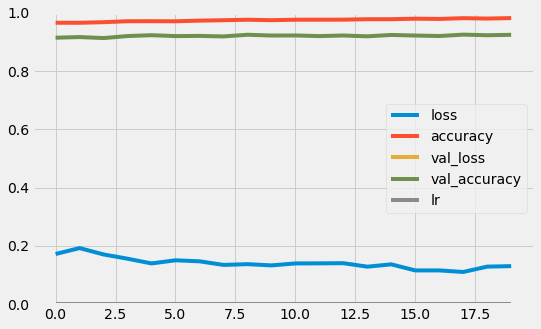

In [ ]:
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#test with the test set taken from file
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)

test_features, test_labels = get_features_and_labels(X_test, labels)
test_labels = keras.utils.to_categorical(labels, NUM_CATEGORIES)

Error in Test/03814.png
Error in Test/03815.png
Error in Test/03817.png


In [ ]:
test_model = keras.models.load_model(
 "feature_extraction_without_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
predict_x=model.predict(test_features) 
pred=np.argmax(predict_x,axis=1)

In [ ]:
#Area under the curve
from sklearn.metrics import roc_auc_score, roc_curve

for i in range(25):
    prediction = pred[i]
    actual = labels[i]
    auc = roc_auc_score(actual, prediction)
    fpr, tpr, thresholds = roc_curve(actual, prediction)
    plt.plot(fpr, tpr, lab=classes[i], label='ROC curve for class {} (AUC = {:.2f})'.format(i, auc))

# Plot the ROC curves
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

### Feature extraction without data augmentation with Adam optimizer

In [ ]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(1,1,512))
x = layers.Flatten()(inputs)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(43, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
#we split the train and test set , 80 - 20 
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)
train_features, train_labels = get_features_and_labels(X_train, y_train)
val_features, val_labels = get_features_and_labels(X_val, y_val)

print("train_features.shape", train_features.shape)
print("valid_features.shape", val_features.shape)
print("train_labels.shape", train_labels.shape)
print("valid_labels.shape", val_labels.shape)

246/246 [==============================] - 4s 18ms/step
train_features.shape (31367, 1, 1, 512)
valid_features.shape (7842, 1, 1, 512)
train_labels.shape (31367,)
valid_labels.shape (7842,)


In [ ]:
train_labels = keras.utils.to_categorical(train_labels, NUM_CATEGORIES)
val_labels = keras.utils.to_categorical(val_labels, NUM_CATEGORIES)

print("train_features.shape", train_features.shape)
print("valid_features.shape", val_features.shape)
print("train_labels.shape", train_labels.shape)
print("valid_labels.shape", val_labels.shape)

train_features.shape (31367, 1, 1, 512)
valid_features.shape (7842, 1, 1, 512)
train_labels.shape (31367, 43)
valid_labels.shape (7842, 43)


In [ ]:
learning_rate = 0.0001
adam = Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
 optimizer=adam,
 metrics=["accuracy"])

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    min_lr=0.000001)

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="feature_extraction_without_data_augmentation.keras",
 save_best_only=True,
 monitor="val_loss"),
 learning_rate_reduction
]

history = model.fit(
 train_features, train_labels,
 epochs=20,
 validation_data=(val_features, val_labels),
 callbacks=callbacks,
 class_weight = class_weights
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


981/981 [==============================] - 4s 4ms/step - loss: 3.8958 - accuracy: 0.3492 - val_loss: 1.5706 - val_accuracy: 0.5843 - lr: 1.0000e-04
Epoch 2/20
981/981 [==============================] - 4s 4ms/step - loss: 1.3827 - accuracy: 0.5771 - val_loss: 1.0547 - val_accuracy: 0.6922 - lr: 1.0000e-04
Epoch 3/20
981/981 [==============================] - 5s 5ms/step - loss: 0.8541 - accuracy: 0.6766 - val_loss: 0.8067 - val_accuracy: 0.7561 - lr: 1.0000e-04
Epoch 4/20
981/981 [==============================] - 4s 4ms/step - loss: 0.5797 - accuracy: 0.7501 - val_loss: 0.6270 - val_accuracy: 0.8015 - lr: 1.0000e-04
Epoch 5/20
981/981 [==============================] - 4s 4ms/step - loss: 0.4429 - accuracy: 0.7999 - val_loss: 0.5621 - val_accuracy: 0.8258 - lr: 1.0000e-04
Epoch 6/20
981/981 [==============================] - 4s 4ms/step - loss: 0.3402 - accuracy: 0.8384 - val_loss: 0.4623 - val_accuracy: 0.8599 - lr: 1.0000e-04
Epoch 7/20
981/981 [==============================] - 4s 

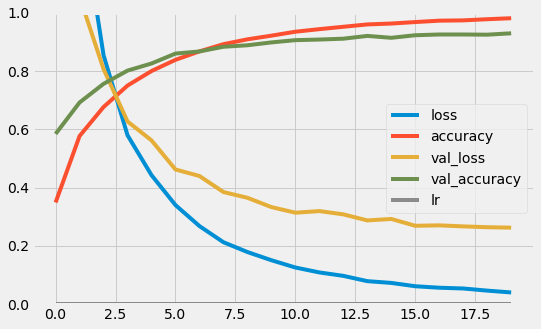

In [ ]:
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#test with the test set taken from before

test_features, test_labels = get_features_and_labels(X_test, labels)
test_labels = keras.utils.to_categorical(labels, NUM_CATEGORIES)

In [ ]:
test_model = keras.models.load_model(
 "feature_extraction_without_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
predict_x=model.predict(test_features) 
pred=np.argmax(predict_x,axis=1)

In [ ]:
#Area under the curve
from sklearn.metrics import roc_auc_score, roc_curve

for i in range(25):
    prediction = pred[i]
    actual = labels[i]
    auc = roc_auc_score(actual, prediction)
    fpr, tpr, thresholds = roc_curve(actual, prediction)
    plt.plot(fpr, tpr, lab=classes[i], label='ROC curve for class {} (AUC = {:.2f})'.format(i, auc))

# Plot the ROC curves
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

## Feature extraction with augmentation 

In [ ]:
#freezing all the layers
conv_base.trainable = False
#Setting trainable to False empties the list of trainable weights of the layer or model
print("Trainable weights after freezing", len(conv_base.trainable_weights))

conv_base.summary()

Trainable weights after freezing 0
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D

### Feature extraction with augmentation with RMSProp optimizer

In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(50,50,3))
x = data_augmentation(inputs, training=True) # apply data augmentation
x = keras.applications.vgg19.preprocess_input(x) # apply input value scaling
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(43, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
#we split the train and test set , 80 - 20 
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

train_features = X_train
train_labels = y_train
val_features = X_val
val_labels = y_val

print("train_features.shape", train_features.shape)
print("valid_features.shape", val_features.shape)
print("train_labels.shape", train_labels.shape)
print("valid_labels.shape", val_labels.shape)

train_features.shape (31367, 50, 50, 3)
valid_features.shape (7842, 50, 50, 3)
train_labels.shape (31367,)
valid_labels.shape (7842,)


In [ ]:
train_labels = keras.utils.to_categorical(train_labels, NUM_CATEGORIES)
val_labels = keras.utils.to_categorical(val_labels, NUM_CATEGORIES)

print("train_features.shape", train_features.shape)
print("valid_features.shape", val_features.shape)
print("train_labels.shape", train_labels.shape)
print("valid_labels.shape", val_labels.shape)

train_features.shape (31367, 50, 50, 3)
valid_features.shape (7842, 50, 50, 3)
train_labels.shape (31367, 43)
valid_labels.shape (7842, 43)


In [ ]:
model.compile(loss='categorical_crossentropy',
 optimizer="rmsprop",
 metrics=["accuracy"])

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    min_lr=0.000001)

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="feature_extraction_with_data_augmentation.keras",
 save_best_only=True,
 monitor="val_loss"),
 learning_rate_reduction
]

history = model.fit(
 train_features, train_labels,
 epochs=30,
 validation_data=(val_features, val_labels),
 callbacks=callbacks,
 class_weight = class_weights
)

Epoch 1/30
981/981 [==============================] - 43s 43ms/step - loss: 2.6492 - accuracy: 0.4823 - val_loss: 1.3367 - val_accuracy: 0.6043
Epoch 2/30
981/981 [==============================] - 48s 49ms/step - loss: 1.5697 - accuracy: 0.6087 - val_loss: 1.2413 - val_accuracy: 0.6688
Epoch 3/30
981/981 [==============================] - 41s 42ms/step - loss: 1.4782 - accuracy: 0.6489 - val_loss: 1.2429 - val_accuracy: 0.6849
Epoch 4/30
981/981 [==============================] - 41s 42ms/step - loss: 1.3923 - accuracy: 0.6689 - val_loss: 1.1902 - val_accuracy: 0.6993
Epoch 5/30
981/981 [==============================] - 41s 42ms/step - loss: 1.4127 - accuracy: 0.6889 - val_loss: 1.1664 - val_accuracy: 0.7033
Epoch 6/30
981/981 [==============================] - 45s 45ms/step - loss: 1.3633 - accuracy: 0.6952 - val_loss: 1.1937 - val_accuracy: 0.7195
Epoch 7/30
981/981 [==============================] - 41s 42ms/step - loss: 1.3650 - accuracy: 0.7073 - val_loss: 1.1500 - val_accuracy:

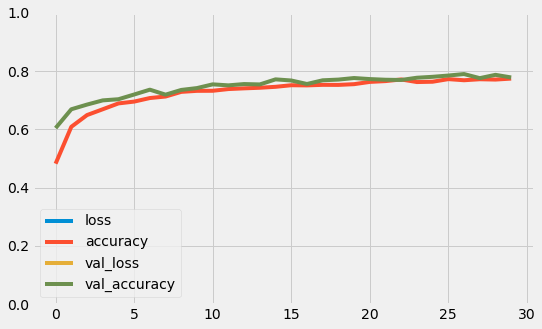

In [ ]:
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#test with the test set taken from file

#X_test = X_test.astype('float32')/255
test_features = X_test
test_labels = keras.utils.to_categorical(labels, NUM_CATEGORIES)

In [ ]:
test_model = keras.models.load_model(
 "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
predict_x=model.predict(test_features) 
pred=np.argmax(predict_x,axis=1)

In [ ]:
#Area under the curve
from sklearn.metrics import roc_auc_score, roc_curve

for i in range(25):
    prediction = pred[i]
    actual = labels[i]
    auc = roc_auc_score(actual, prediction)
    fpr, tpr, thresholds = roc_curve(actual, prediction)
    plt.plot(fpr, tpr, lab=classes[i], label='ROC curve for class {} (AUC = {:.2f})'.format(i, auc))

# Plot the ROC curves
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

### Feature extraction with augmentation with Adam optimizer

In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(50,50,3))
x = data_augmentation(inputs, training=True) # apply data augmentation
x = keras.applications.vgg19.preprocess_input(x) # apply input value scaling
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(43, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
#we split the train and test set , 80 - 20 
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

train_features = X_train
train_labels = y_train
val_features = X_val
val_labels = y_val

print("train_features.shape", train_features.shape)
print("valid_features.shape", val_features.shape)
print("train_labels.shape", train_labels.shape)
print("valid_labels.shape", val_labels.shape)

In [ ]:
train_labels = keras.utils.to_categorical(train_labels, NUM_CATEGORIES)
val_labels = keras.utils.to_categorical(val_labels, NUM_CATEGORIES)

print("train_features.shape", train_features.shape)
print("valid_features.shape", val_features.shape)
print("train_labels.shape", train_labels.shape)
print("valid_labels.shape", val_labels.shape)

In [ ]:
learning_rate = 0.0001
adam = Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
 optimizer=adam,
 metrics=["accuracy"])

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    min_lr=0.000001)

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="feature_extraction_with_data_augmentation.keras",
 save_best_only=True,
 monitor="val_loss"),
 learning_rate_reduction
]

history = model.fit(
 train_features, train_labels,
 epochs=30,
 validation_data=(val_features, val_labels),
 callbacks=callbacks,
 class_weight = class_weights
)

In [ ]:
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#test with the test set taken from file

#X_test = X_test.astype('float32')/255
test_features = X_test
test_labels = keras.utils.to_categorical(labels, NUM_CATEGORIES)

In [ ]:
test_model = keras.models.load_model(
 "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
predict_x=model.predict(test_features) 
pred=np.argmax(predict_x,axis=1)

In [ ]:
#Area under the curve
from sklearn.metrics import roc_auc_score, roc_curve

for i in range(25):
    prediction = pred[i]
    actual = labels[i]
    auc = roc_auc_score(actual, prediction)
    fpr, tpr, thresholds = roc_curve(actual, prediction)
    plt.plot(fpr, tpr, lab=classes[i], label='ROC curve for class {} (AUC = {:.2f})'.format(i, auc))

# Plot the ROC curves
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

## Fine Tuning

In [ ]:
from tensorflow.keras import layers

# data augmentation layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# initialize the model
inputs = keras.Input(shape=(50,50,3))
x = data_augmentation(inputs, training=True) # apply data augmentation
x = keras.applications.vgg19.preprocess_input(x) # apply input value scaling
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(43, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
# Freezing all layers until the fifth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-5]:
 layer.trainable = False

In [ ]:
conv_base.summary()

### Fine tuning with the RMSprop optimizer

In [ ]:
#we split the train and test set , 80 - 20 
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

train_features = X_train
train_labels = y_train
val_features = X_val
val_labels = y_val

print("train_features.shape", train_features.shape)
print("valid_features.shape", val_features.shape)
print("train_labels.shape", train_labels.shape)
print("valid_labels.shape", val_labels.shape)

In [ ]:
train_labels = keras.utils.to_categorical(train_labels, NUM_CATEGORIES)
val_labels = keras.utils.to_categorical(val_labels, NUM_CATEGORIES)

print("train_features.shape", train_features.shape)
print("valid_features.shape", val_features.shape)
print("train_labels.shape", train_labels.shape)
print("valid_labels.shape", val_labels.shape)

In [ ]:
model.compile(loss='categorical_crossentropy',
 optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
 metrics=["accuracy"])

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="fine_tuning.keras",
 save_best_only=True,
 monitor="val_loss"),
 learning_rate_reduction
]

history = model.fit(
 train_features, train_labels,
 epochs=20,
 validation_data=(val_features, val_labels),
 callbacks=callbacks,
 class_weight = class_weights
)

In [ ]:
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# take the test set from before
test_features = X_test
test_labels = keras.utils.to_categorical(labels, NUM_CATEGORIES)

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels) 
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
predict_x=model.predict(test_features) 
pred=np.argmax(predict_x,axis=1)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Area under the curve
from sklearn.metrics import roc_auc_score, roc_curve

for i in range(25):
    prediction = pred[i]
    actual = labels[i]
    auc = roc_auc_score(actual, prediction)
    fpr, tpr, thresholds = roc_curve(actual, prediction)
    plt.plot(fpr, tpr, lab=classes[i], label='ROC curve for class {} (AUC = {:.2f})'.format(i, auc))

# Plot the ROC curves
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

### Fine tuning with the Adam optimizer

In [ ]:
#we split the train and test set , 80 - 20 
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

train_features = X_train
train_labels = y_train
val_features = X_val
val_labels = y_val

print("train_features.shape", train_features.shape)
print("valid_features.shape", val_features.shape)
print("train_labels.shape", train_labels.shape)
print("valid_labels.shape", val_labels.shape)

In [ ]:
train_labels = keras.utils.to_categorical(train_labels, NUM_CATEGORIES)
val_labels = keras.utils.to_categorical(val_labels, NUM_CATEGORIES)

print("train_features.shape", train_features.shape)
print("valid_features.shape", val_features.shape)
print("train_labels.shape", train_labels.shape)
print("valid_labels.shape", val_labels.shape)

In [ ]:
learning_rate = 0.0001
adam = Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
 optimizer=adam,
 metrics=["accuracy"])

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="fine_tuning.keras",
 save_best_only=True,
 monitor="val_loss"),
 learning_rate_reduction
]

history = model.fit(
 train_features, train_labels,
 epochs=20,
 validation_data=(val_features, val_labels),
 callbacks=callbacks,
 class_weight = class_weights
)

In [ ]:
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# take the test set from before
test_features = X_test
test_labels = keras.utils.to_categorical(labels, NUM_CATEGORIES)

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels) 
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
predict_x=model.predict(test_features) 
pred=np.argmax(predict_x,axis=1)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Area under the curve
from sklearn.metrics import roc_auc_score, roc_curve

for i in range(25):
    prediction = pred[i]
    actual = labels[i]
    auc = roc_auc_score(actual, prediction)
    fpr, tpr, thresholds = roc_curve(actual, prediction)
    plt.plot(fpr, tpr, lab=classes[i], label='ROC curve for class {} (AUC = {:.2f})'.format(i, auc))

# Plot the ROC curves
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

# **Fast R-CNN**

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Add, Input, Flatten, Dense
from keras.applications import VGG19
from keras import backend as K

In [ ]:
#define the number of anchor boxes
#rule of thumb: start with small values
num_anchors = 5
#TODO: optimize this hyperparameter?

In [ ]:
#we split the train and test set , 80 - 20 
X_train, X_val, Y_train, Y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)
Y_train = keras.utils.to_categorical(Y_train, NUM_CATEGORIES)
Y_val = keras.utils.to_categorical(Y_val, NUM_CATEGORIES)

print(Y_train.shape)
print(Y_val.shape)

(31367, 43)
(7842, 43)


In [ ]:
def define_rpn(features):
    print(features.shape)
    feature_shape = K.int_shape(features)
    
    # Reshape the features tensor to the correct shape
    features = keras.layers.Reshape(target_shape=(feature_shape[1], feature_shape[2], 512))(features)
    
    # Define the input to the RPN
    input_tensor = Input(shape=K.int_shape(features)[1:])
    print(input_tensor.shape)
    
    # Apply a series of convolutional layers to the input tensor
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(input_tensor)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    
    # Generate the region proposals and objectness scores
    rpn_output = Conv2D(2 * num_anchors, (1, 1), padding='same', activation='sigmoid')(x)
    
    # Build the model using the Model class
    model = keras.Model(inputs=input_tensor, outputs=rpn_output)
    
    return model


In [ ]:
def define_detection_network(features):
    # Define the input to the detection network
    print(features.shape)
    
    feature_shape = K.int_shape(features)
    
    features = keras.layers.Reshape(target_shape=(1, 1, 512))(features)
    
    # Define the input to the RPN
    input_tensor = Input(shape=K.int_shape(features)[1:])
    
    # Apply a series of convolutional layers to the features
    x = Conv2D(1024, (3, 3), padding='same', activation='relu')(input_tensor)
    x = Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
    
    # Generate the class predictions and bounding boxes
    detection_output = Conv2D(NUM_CATEGORIES * 4, (1, 1), padding='same', activation='sigmoid')(x)
    
    # Build the model using the Model class
    model = keras.Model(inputs=input_tensor, outputs=detection_output)
    
    return model

In [ ]:
def define_anchor_boxes():
    # Define the anchor box shapes and scales
    anchor_shapes = [(32, 32), (64, 64), (128, 128), (256, 256), (512, 512)]
    anchor_scales = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]
    
    # Generate the anchor boxes
    anchor_boxes = []
    for shape in anchor_shapes:
        for scale in anchor_scales:
            anchor_boxes.append((shape[0] * scale, shape[1] * scale))
    
    return anchor_boxes

In [ ]:
def faster_rcnn_model(input_tensor, features):
    # Define the anchor boxes
    anchor_boxes = define_anchor_boxes()
    
    # Define the region proposal network (RPN)
    rpn = define_rpn(features)
    
    # Get the region proposals from the RPN
    region_proposals = rpn(input_tensor)
    print("rp",region_proposals.shape)
    
    # Define the object detection network
    detection_network = define_detection_network(features)

    #region_proposals = keras.layers.Reshape(target_shape=(1, 1, 512))(region_proposals)
    
    # Get the object detections from the detection network
    detections = detection_network(region_proposals)
    
    # Build the model using the Model class
    model = keras.Model(inputs=input_tensor, outputs=detections)
    
    return model

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.layers import Input

# Load the VGG19 model
vgg_model = VGG19(include_top=False, weights='imagenet', input_shape=(50,50,3))

# Extract the features from the VGG19 model
features = vgg_model.output
print(features.shape)

# Define the input to the model
input_tensor = Input(shape=(1, 1, 512))

# Build the Faster R-CNN model using the VGG19 features and the input tensor
model = faster_rcnn_model(input_tensor=input_tensor, features=features)

# Compile and fit the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

(None, 1, 1, 512)
(None, 1, 1, 512)
(None, 1, 1, 512)
rp (None, 1, 1, 10)
(None, 1, 1, 512)


ValueError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class ROIPoolingLayer(Layer):
    """ Implements Region Of Interest Max Pooling 
        for channel-first images and relative bounding box coordinates
        
        # Constructor parameters
            pooled_height, pooled_width (int) -- 
              specify height and width of layer outputs
        
        Shape of inputs
            [(batch_size, pooled_height, pooled_width, n_channels),
             (batch_size, num_rois, 4)]
           
        Shape of output
            (batch_size, num_rois, pooled_height, pooled_width, n_channels)
    
    """
    def __init__(self, pooled_height, pooled_width, **kwargs):
        self.pooled_height = pooled_height
        self.pooled_width = pooled_width
        
        super(ROIPoolingLayer, self).__init__(**kwargs)
        
    def compute_output_shape(self, input_shape):
        """ Returns the shape of the ROI Layer output
        """
        feature_map_shape, rois_shape = input_shape
        assert feature_map_shape[0] == rois_shape[0]
        batch_size = feature_map_shape[0]
        n_rois = rois_shape[1]
        n_channels = feature_map_shape[3]
        return (batch_size, n_rois, self.pooled_height, 
                self.pooled_width, n_channels)

    def __call__(self, x):
        """ Maps the input tensor of the ROI layer to its output
        
            # Parameters
                x[0] -- Convolutional feature map tensor,
                        shape (batch_size, pooled_height, pooled_width, n_channels)
                x[1] -- Tensor of region of interests from candidate bounding boxes,
                        shape (batch_size, num_rois, 4)
                        Each region of interest is defined by four relative 
                        coordinates (x_min, y_min, x_max, y_max) between 0 and 1
            # Output
                pooled_areas -- Tensor with the pooled region of interest, shape
                    (batch_size, num_rois, pooled_height, pooled_width, n_channels)
        """
        def curried_pool_rois(x): 
          return ROIPoolingLayer._pool_rois(x[0], x[1], 
                                            self.pooled_height, 
                                            self.pooled_width)
        
        pooled_areas = tf.map_fn(curried_pool_rois, x, dtype=tf.float32)

        return pooled_areas
    
    @staticmethod
    def _pool_rois(feature_map, rois, pooled_height, pooled_width):
        """ Applies ROI pooling for a single image and varios ROIs
        """
        def curried_pool_roi(roi): 
          return ROIPoolingLayer._pool_roi(feature_map, roi, 
                                           pooled_height, pooled_width)
        
        pooled_areas = tf.map_fn(curried_pool_roi, rois, dtype=tf.float32)
        return pooled_areas
    
    @staticmethod
    def _pool_roi(feature_map, roi, pooled_height, pooled_width):
        """ Applies ROI pooling to a single image and a single region of interest
        """

        # Compute the region of interest        
        feature_map_height = int(feature_map.shape[0])
        feature_map_width  = int(feature_map.shape[1])
        
        h_start = tf.cast(feature_map_height * roi[0], 'int32')
        w_start = tf.cast(feature_map_width  * roi[1], 'int32')
        h_end   = tf.cast(feature_map_height * roi[2], 'int32')
        w_end   = tf.cast(feature_map_width  * roi[3], 'int32')
        
        region = feature_map[h_start:h_end, w_start:w_end, :]
        
        # Divide the region into non overlapping areas
        region_height = h_end - h_start
        region_width  = w_end - w_start
        h_step = tf.cast( region_height / pooled_height, 'int32')
        w_step = tf.cast( region_width  / pooled_width , 'int32')
        
        areas = [[(
                    i*h_step, 
                    j*w_step, 
                    (i+1)*h_step if i+1 < pooled_height else region_height, 
                    (j+1)*w_step if j+1 < pooled_width else region_width
                   ) 
                   for j in range(pooled_width)] 
                  for i in range(pooled_height)]
        
        # take the maximum of each area and stack the result
        def pool_area(x): 
          return tf.math.reduce_max(region[x[0]:x[2], x[1]:x[3], :], axis=[0,1])
        
        pooled_features = tf.stack([[pool_area(x) for x in row] for row in areas])
        return pooled_features

In [ ]:
#we split the train and test set , 80 - 20 
X_train, X_val, Y_train, Y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)
Y_train = keras.utils.to_categorical(Y_train, NUM_CATEGORIES)
Y_val = keras.utils.to_categorical(Y_val, NUM_CATEGORIES)

print(Y_train.shape)
print(Y_val.shape)

(31367, 43)
(7842, 43)


In [ ]:
# create the CNN backbone
inputs = Input(shape=(50, 50, 3))
cnn = Conv2D(64, (3, 3), activation='relu')(inputs)
cnn = Conv2D(64, (3, 3), activation='relu')(cnn)
cnn = Conv2D(128, (3, 3), activation='relu')(cnn)
cnn = Conv2D(128, (3, 3), activation='relu')(cnn)

# create the RPN layers
rpn = Conv2D(256, (3, 3), activation='relu', name='rpn_conv_1')(cnn)
rpn_cls = Conv2D(2 * num_anchors, (1, 1), activation='sigmoid', name='rpn_out_class')(rpn)
rpn_reg = Conv2D(4 * num_anchors, (1, 1), activation='linear', name='rpn_out_regress')(rpn)
"""
# rpn_reg = np.asarray(rpn_reg).astype('float32')
# create the Fast R-CNN head
roi_pooling = ROIPoolingLayer(7, 7)(rpn_reg)
fc1 = Flatten()(roi_pooling)
fc1 = Dense(4096, activation='relu')(fc1)
fc2 = Dense(4096, activation='relu')(fc1)
class_scores = Dense(NUM_CATEGORIES, activation='softmax')(fc2)
"""

fc1 = Flatten()(rpn_reg)
fc1 = Dense(4096, activation='relu')(fc1)
fc2 = Dense(4096, activation='relu')(fc1)
class_scores = Dense(NUM_CATEGORIES, activation='softmax')(fc2)

In [ ]:
# create the model
model = keras.Model(inputs=inputs, outputs=class_scores)


#early stopping
early_stopper = tf.keras.callbacks.EarlyStopping(patience = 5, monitor='val_loss')
#learning rate reduction
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    min_lr=0.000001)

callbacks = [keras.callbacks.ModelCheckpoint(
 filepath="rcnn.keras",
 save_best_only=True,
 monitor="val_loss"),
 early_stopper,
 learning_rate_reduction
]

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# fit the model on the training data
model.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val), callbacks=callbacks, class_weight = class_weights)

Epoch 1/20
398/981 [===========>..................] - ETA: 39s - loss: 10.3076 - accuracy: 0.0168

KeyboardInterrupt: ignored

In [ ]:
#test with the test set taken from file
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
#X_test = X_test.astype('float32')/255

test_features = X_test
test_labels = keras.utils.to_categorical(labels, NUM_CATEGORIES)

In [ ]:
# test the model
test_model = keras.models.load_model(
 "rcnn.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
# plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Using VGG19 as the backbone

In [ ]:
from keras.applications import VGG19

# load the VGG19 model pretrained on ImageNet
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# remove the top FC layers from the VGG19 model
x = vgg19.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
class_scores = Dense(NUM_CATEGORIES, activation='softmax')(x)

# create the RPN layers
rpn = Conv2D(256, (3, 3), activation='relu', name='rpn_conv_1')(vgg19.output)
rpn_cls = Conv2D(2 * num_anchors, (1, 1), activation='sigmoid', name='rpn_out_class')(rpn)
rpn_reg = Conv2D(4 * num_anchors, (1, 1), activation='linear', name='rpn_out_regress')(rpn)

# create the Fast R-CNN head
roi_pooling = RoIPooling2D(pool_size=(7, 7))(vgg19.output, rpn_reg)
fc1 = Flatten()(roi_pooling)
fc1 = Dense(4096, activation='relu')(fc1)
fc2 = Dense(4096, activation='relu')(fc1)
class_scores = Dense(NUM_CATEGORIES, activation='softmax')(fc2)

ValueError: ignored

In [ ]:
# create the model
inputs = vgg19.input
model = keras.Model(inputs=inputs, outputs=class_scores)

# freeze the layers of the VGG19 model
for layer in vgg19.layers:
    layer.trainable = False

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
 filepath="rcnn-vgg19.keras",
 save_best_only=True,
 monitor="val_loss"),
 early_stopper,
 learning_rate_reduction
]

# fit the model on the training data
model.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val), callbacks=callbacks,class_weight = class_weights)

In [ ]:
# test the model
test_model = keras.models.load_model(
 "rcnn-vgg19.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
# plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()